# Data Plotting

This notebook provides a tutorial for plotting the output of tidy3d simulations.

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../../tidy3d')
import tidy3d as td
import tidy3d.web as web

## Setup

### Creating Simulation

First, let's make a `td.Simulation` so we have data to plot.

In [2]:
# make samplers that define the freq and time domain measurement
freqs = np.linspace(1e14, 3e14, 101)
num_modes = 3

simulation = td.Simulation(
    size=(5.0, 5.0, 5.0),
    grid_size=(0.05, 0.05, 0.05),
    run_time = 5e-12,
    pml_layers = 3*[td.PML()],
    structures = [
        td.Structure(
            geometry=td.Box(center=(0,0,0), size=(2,2,2)),
            medium=td.Medium(permittivity=2),
            name='box'
        ),
        td.Structure(
            geometry=td.Box(center=(0,0,0), size=(10001,1.5,1.5)),
            medium=td.Medium(permittivity=2),
            name='waveguide'
        )        
    ],
    sources=[td.ModeSource(
        source_time=td.GaussianPulse(freq0=2e14, fwidth=3e13),
        center=(-2.0, 0.0, 0.0),
        size=(0.0, 2, 2),
        direction='+',
        mode=td.Mode(mode_index=0)
    )],
    monitors=[
        td.FieldMonitor(
            fields=['Ex', 'Ey', 'Ez'],
            size=(5, 0, 5),
            center=(0,0,0),
            freqs=freqs,
            name='field'),
        td.FieldTimeMonitor(
            size=(5, 0, 5),
            center=(0,0,0),
            interval=30,
            name='field_time'),
        td.FluxMonitor(
            size=(0,2,2),
            center=(2,0,0),
            freqs=freqs, 
            name='flux'),
        td.FluxTimeMonitor(
            size=(0,2,2),
            center=(2,0,0),
            interval=10,
            name='flux_time'),
        td.ModeMonitor(
            size=(0,2,2),
            center=(2,0,0),
            freqs=freqs,
            modes=[td.Mode(mode_index=i) for i in range(num_modes)], 
            name='mode')
    ],
)

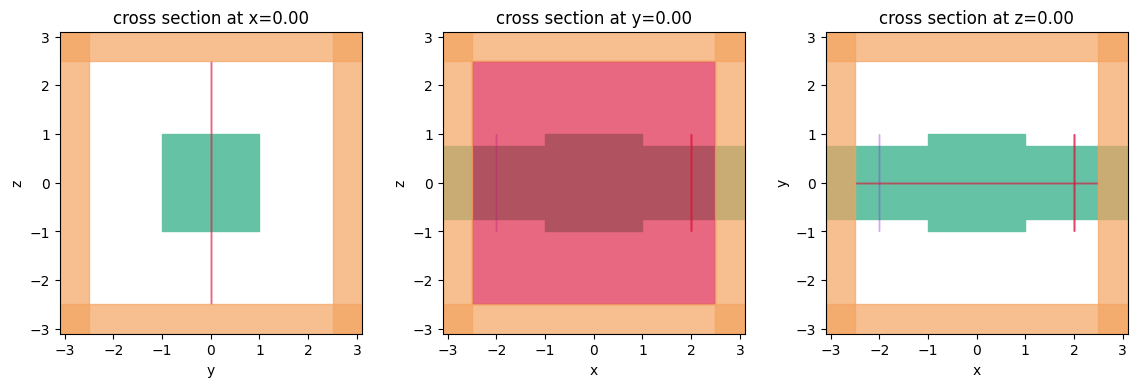

In [3]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
simulation.plot(x=0.0, ax=ax1)
simulation.plot(y=0.0, ax=ax2)
simulation.plot(z=0.0, ax=ax3)
plt.show()

In [4]:
# sim_data = web.run(simulation, task_name='viz_sim_data', path='data/simulation.hdf5')
sim_data = web.load_data('03a82b08-45ef-45e9-bdb8-266f813554ac', simulation, path='data/simulation.hdf5')
print(sim_data.log)

[18:48:29] INFO     downloading file "simulation.json" to                       ]8;id=740729;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:388
                    "data/simulation.json"

Output()

           INFO     downloading file "monitor_data.hdf5" to                     ]8;id=416040;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:388
                    "data/monitor_data.hdf5"

Output()

[18:48:33] INFO     downloading file "tidy3d.log" to "data/tidy3d.log"          ]8;id=860059;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:388

Output()

           INFO     exporting SimulationData to data/simulation.hdf5            ]8;id=598659;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:261

           INFO     loading SimulationData from data/simulation.hdf5            ]8;id=109922;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:297

Simulation domain Nx, Ny, Nz: [124, 124, 124]
Applied symmetries: [0, 0, 0]
Number of computational grid points: 1.9066e+06.
Using subpixel averaging: True
Number of time steps: 11540
Automatic shutoff factor: 1.00e-05
Time step (s): 8.6662e-17

Get source modes time (s):    0.2509
Get monitor modes time (s):   0.4743
Rest of setup time (s):       0.0347

Starting solver...
- Time step    306 / time 2.65e-14s (  2 % done), field decay: 1.00e+00
- Time step    461 / time 4.00e-14s (  4 % done), field decay: 1.00e+00
- Time step    923 / time 8.00e-14s (  8 % done), field decay: 4.97e-06
Field decay smaller than shutoff factor, exiting solver.

Solver time (s):              1.7635
Post-processing time (s):     0.8260



## Plotting

Here we show how to plot data from each monitor

### Flux Data

`td.FluxData` and `td.FluxTimeData` is the simplest because it just stores the electromagnetic power flux through a surface as a function of the frequency and time, respectively.

First, we access the `td.MonitorData` through the dictionary `sim_data.monitor_data`.

In [5]:
# get the flux data from that monitor name
flux_data = sim_data['flux']
flux_time_data = sim_data['flux_time']

and we can plot the values using the `td.MonitorData.plot()` method.

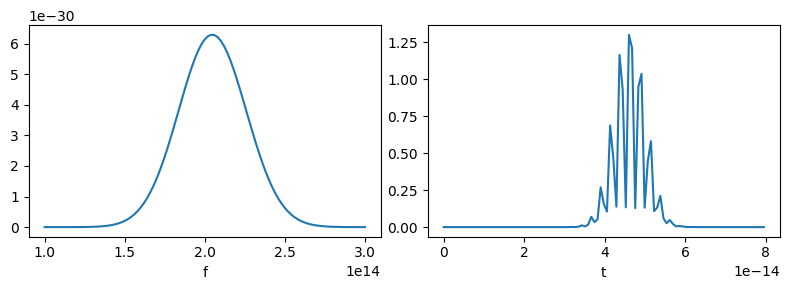

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8,3))
flux_data.real.plot(ax=ax1)
flux_time_data.plot(ax=ax2)

plt.show()

## Plotting Mode Data

The axes of mode data correspond to direction (+/-), mode_index, and sampler axes. 

To pot all of this data, we make two subplots and use the builting `.sel()` function to select the data to plot in each axis.

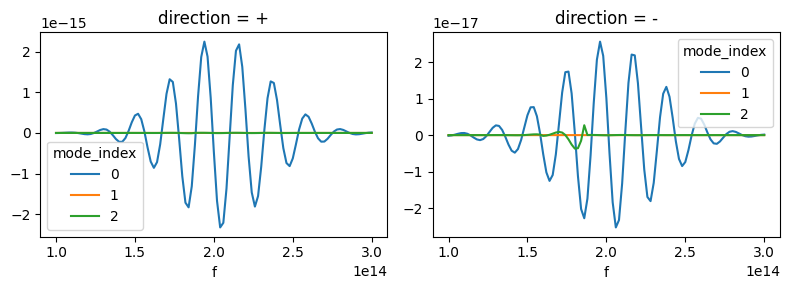

In [7]:
# tip: you can also get the monitor data directly by indexing it's name in `SimulationData`
mode_data = sim_data['mode']

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 3))

mode_data.sel(direction='+').real.plot.line(x='f', ax=ax1)
mode_data.sel(direction='-').real.plot.line(x='f', ax=ax2)
plt.show()


### Plotting Fields

Let's grab the field data and plot.

In [8]:
field_data = sim_data['field']

#### Electromagnetic Fields

In [9]:
# get the field data on the z=1.0 plane at frequency 200THz
field_data = sim_data['field'].interp(f=200e12).sel(y=0)

##### Amplitude Plots

In [10]:
# amplitude plot rz Ex(x,y) field on plane
field_data['Ez']
plt.show()

##### Quiver Plots

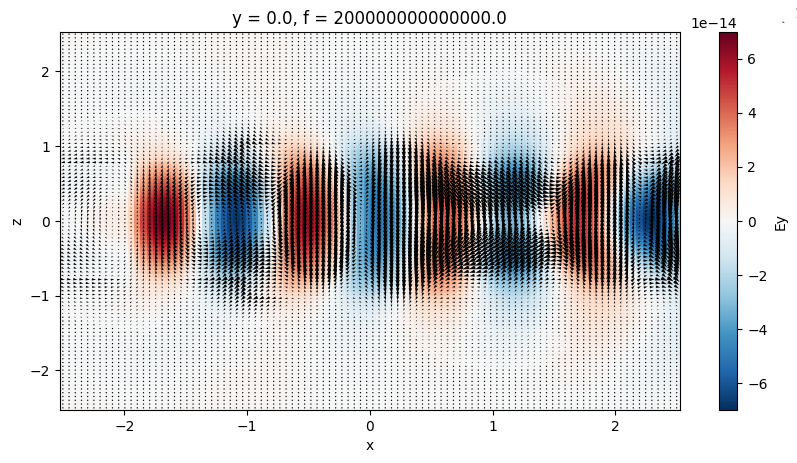

In [11]:
# quiver plot of E_{x,y}(x,y) on plane with Ez(x,y) underlying.
f, ax = plt.subplots(figsize=(10, 5))
field_data['Ey'].real.plot(x='x', y='z', ax=ax)
field_data.real.plot.quiver('x', 'z', 'Ez', 'Ex', ax=ax)
plt.show()

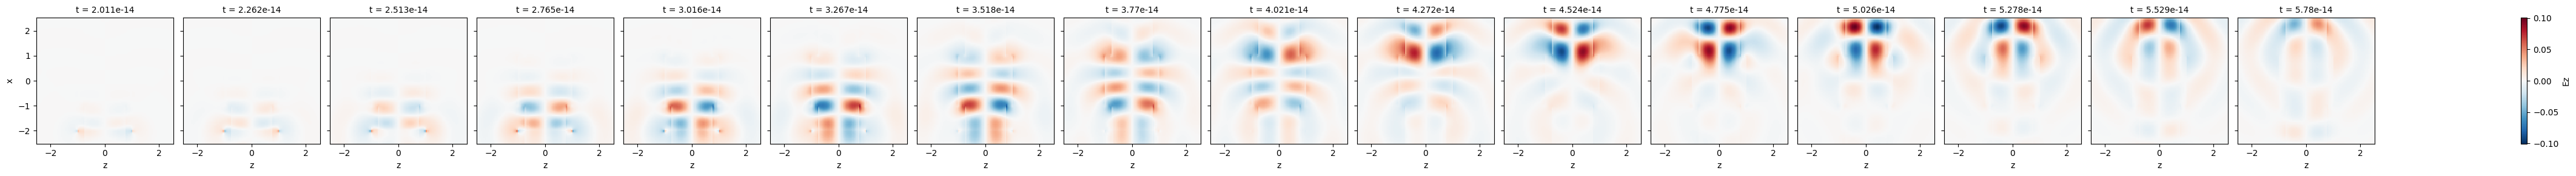

In [12]:
field_time_data = sim_data['field_time']

time_data = field_time_data.sel(y=0, t=slice(2e-14, 6e-14))

_ = time_data['Ez'].plot(col='t')

In [22]:
't' in sim_data['field_time'].coords

True

##### Structure Overlay
One can overlay the structure permittivity by calling `plot_fields` from the `td.SimulationData` object as follows:

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_68283/3244258097.py:1 in       │
│ <module>                                                                                  │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_68283/3244258097.py'          │
│ /Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/comp │
│ onents/viz.py:32 in _plot                                                                 │
│                                                                                           │
│    29 │   │   if kwargs.get("ax") is None:                                                │
│    30 │   │   │   ax = make_ax()                                                          │
│    31 │   │   │   kwargs["ax"] = ax                                                       │
│ ❱  32 │   │   return plot(*args, **kwargs)                                                │
│    33 │                                                                                   │
│    34 │   return _plot                                                                    │
│    35                                                                                     │
│                                                                                           │
│ /Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/comp │
│ onents/data.py:594 in plot_field                                                          │
│                                                                                           │
│   591 │   │   # select the frequency or time value                                        │
│   592 │   │   if isinstance(monitor_data, FieldData):                                     │
│   593 │   │   │   if freq is None:                                                        │
│ ❱ 594 │   │   │   │   raise DataError("'freq' must be supplied to plot a FieldMonitor.")  │
│   595 │   │   │   field_data = xr_data.interp(f=freq)                                     │
│   596 │   │   else:                                                                       │
│   597 │   │   │   if time is None:                                                        │
│                                                                                           │
│ /usr/local/lib/python3.9/site-packages/xarray/core/dataarray.py:1725 in interp            │
│                                                                                           │
│   1722 │   │   │   │   "interp only works for a numeric type array. "                     │
│   1723 │   │   │   │   "Given {}.".format(self.dtype)                                     │
│   1724 │   │   │   )                                                                      │
│ ❱ 1725 │   │   ds = self._to_temp_dataset().interp(                                       │
│   1726 │   │   │   coords,                                                                │
│   1727 │   │   │   method=method,                                                         │
│   1728 │   │   │   kwargs=kwargs,                                                         │
│                                                                                           │
│ /usr/local/lib/python3.9/site-packages/xarray/core/dataset.py:3085 in interp              │
│                                                                                           │
│   3082 │   │   │   kwargs = {}                                                            │
│   3083 │   │                                      

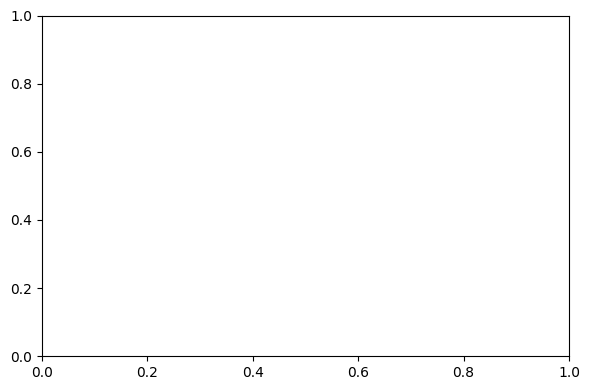

In [16]:
ax = sim_data.plot_field('field_time', 'Ex', y=0.0, freq=200e12, eps_alpha=0.2)

#### Permittivity

If we've stored permittivity by specifing `eps_xx`, `eps_yy` or `eps_zz` in the `FieldMonitor`'s `fields`, we can access them and plot as follows.

In [ ]:
# eps_xx = field_data.eps_xx
# xx_component_plane = eps_xx.interp(z=1.0, f=7.5)
# xx_component_plane.real.plot(cmap='gist_yarg')
# plt.show()

## Tricks and Tips

The `td.MonitorData` objects can be found by indexing `td.SimulationData` directly.

In [ ]:
assert np.all(sim_data.monitor_data['mode'].data == sim_data['mode'])

Keyword arguments are passed to the correponding `.plot()` calls internally, so you can customize the plots.

In [ ]:
sim_data['flux'].plot(color='brown', linestyle='-.', label='custom line')
plt.legend()
plt.title('custom plot')
plt.show()